## Getting Clouds

In [271]:
import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [272]:
sims_file = '../01_GeneratePureSpectrums/sims_01.csv'
res_info_folder = '../01_GeneratePureSpectrums/ResInfo/res_info_'
sims_df = pd.read_csv(sims_file)
print(sims_df)
pickle_files = '../01_GeneratePureSpectrums/specs/'+sims_df['filename']+'.pkl'

   soil_resolution         function    id                      filename
0            7x7x7               Si  1000               7x7x7_Si_001000
1            7x7x7               Al  1001               7x7x7_Al_001001
2            7x7x7                H  1002                7x7x7_H_001002
3            7x7x7               Na  1003               7x7x7_Na_001003
4            7x7x7                O  1004                7x7x7_O_001004
5            7x7x7               Fe  1005               7x7x7_Fe_001005
6            7x7x7               Mg  1006               7x7x7_Mg_001006
7            7x7x7                C  1007                7x7x7_C_001007
8            7x7x7             SiO2  1008             7x7x7_SiO2_001008
9            7x7x7            Al2O3  1009            7x7x7_Al2O3_001009
10           7x7x7              H2O  1010              7x7x7_H2O_001010
11           7x7x7             Na2O  1011             7x7x7_Na2O_001011
12           7x7x7            Fe2O3  1012            7x7x7_Fe2O3

In [273]:
filenames = [sims_df['filename'][i] for i in range(len(sims_df))]
res_info_files = [res_info_folder + str(soil_resolution) + '.json' for soil_resolution in sims_df['soil_resolution']]
res_infos = [json.load(open(res_info_file, 'r')) for res_info_file in res_info_files]
sidess = [res_info['sides'] for res_info in res_infos]


In [274]:
filenames = []
n_90 = []
n_95 = []
n_99 = []
n_100 = []
n_total = []

clouds = {
    '90': [],
    '95': [],
    '99': [],
    '100': []
}

for i in range(len(sims_df)):

    pickle_file = pickle_files[i]
    soil_resolution = sims_df['soil_resolution'][i]
    res_info_file = res_info_folder + str(soil_resolution) + '.json'
    res_info = json.load(open(res_info_file, 'r'))
    midpoints = np.array(res_info['midpoints'])
    detector_tally_ids = [int(r) for r in res_info['detector_tally_ids']]
    cell_ids = [int(r) for r in res_info['cell_ids']]
    filename = sims_df['filename'][i]
    i_bins, i_spectrums= pickle.load(open(pickle_file, 'rb'))
    detector_energy_bins = i_bins[0][-2]
    detector_spec = i_spectrums[0]
    causal_bins = [str(bin)[:len(str(cell_ids[0]))] for bin in i_bins[4][2]]
    causal_bins = (np.array(causal_bins)).astype(int).tolist()
    causal_energy_bins = i_bins[4][-2]
    causal_spec = i_spectrums[4]
    new_shape = np.array(causal_spec.shape)
    new_shape[2] = len(cell_ids)
    new_array = np.zeros(new_shape)
    for j in range(len(cell_ids)):
        if cell_ids[j] in causal_bins:
            new_array[:, :, j] = causal_spec[:, :, causal_bins.index(cell_ids[j])]
    full_causal_spec = new_array
    cell_heating = full_causal_spec[0, 0, :, 0, 0, 0, :, 0]
    total_soil_heating = np.sum(cell_heating, axis=0)
    cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)
    cells_over_total_heating = cells_over_total_heating/np.sum(cells_over_total_heating)
    cell_portion = np.sum(cells_over_total_heating, axis=1)

    sorted_indicies = np.argsort(cell_portion)[::-1]
    sorted_vals = (cell_portion)[sorted_indicies]
    def percent_cloud(sorted_indicies, sorted_vals, threshold=0.90):
        total = np.sum(sorted_vals)
        cumulative_sum = np.cumsum(sorted_vals)
        percent = cumulative_sum / total
        return sorted_indicies[percent < threshold]
    cell_portion = np.sum(cells_over_total_heating, axis=1)


    filenames.append(filename)
    
    cloud_90 = percent_cloud(sorted_indicies, sorted_vals, threshold=.90)
    clouds['90'].append(cloud_90)
    n_90.append(len(cloud_90))

    cloud_95 = percent_cloud(sorted_indicies, sorted_vals, threshold=.95)
    clouds['95'].append(cloud_95)
    n_95.append(len(cloud_95))

    cloud_99 = percent_cloud(sorted_indicies, sorted_vals, threshold=.99)
    clouds['99'].append(cloud_99)
    n_99.append(len(cloud_99))

    cloud_100 = percent_cloud(sorted_indicies, sorted_vals, threshold=1.0)
    clouds['100'].append(cloud_100)
    n_100.append(len(cloud_100))

    n_total.append(len(sorted_indicies))

results_df = pd.DataFrame({
    'filename': filenames,
    'n_90': n_90,
    'n_95': n_95,
    'n_99': n_99,
    'n_100': n_100,
    'n_total': n_total
})

clouds_df = pd.DataFrame({
    'filename': filenames,
    'cloud_90': clouds['90'],
    'cloud_95': clouds['95'],
    'cloud_99': clouds['99'],
})

results_df.to_csv('n_cells_over_total_heating.csv', index=False)
print(results_df)

                        filename  n_90  n_95  n_99  n_100  n_total
0                7x7x7_Si_001000    27    48   118    343      343
1                7x7x7_Al_001001    25    45   104    315      343
2                 7x7x7_H_001002    34    42    52    343      343
3                7x7x7_Na_001003    76   119   205    316      343
4                 7x7x7_O_001004    67    83   115    343      343
5                7x7x7_Fe_001005     8    15    48    343      343
6                7x7x7_Mg_001006    30    51   124    316      343
7                 7x7x7_C_001007    23    37    84    308      343
8              7x7x7_SiO2_001008    22    38    89    307      343
9             7x7x7_Al2O3_001009    12    21    54    275      343
10              7x7x7_H2O_001010    33    53   113    343      343
11             7x7x7_Na2O_001011    30    51   117    313      343
12            7x7x7_Fe2O3_001012    11    18    50    287      343
13              7x7x7_MgO_001013    17    29    74    343     

/tmp/ipykernel_3777934/2775185049.py:41: RuntimeWarning: invalid value encountered in divide
  cells_over_total_heating = np.nan_to_num(np.divide(cell_heating, total_soil_heating), copy=False, nan=0.0, posinf=None, neginf=None)


In [275]:
# clouds_df

## 3d plotting

In [276]:
def plot_box(ax, xmin, xmax, ymin, ymax, zmin, zmax, color, alpha=1, label=None, zorder=None):
    # Draw a rectangular box (RPP)
    x = [xmin, xmax]
    y = [ymin, ymax]
    z = [zmin, zmax]
    for s, e in [
        # bottom
        ([x[0], y[0], z[0]], [x[1], y[0], z[0]]),
        ([x[1], y[0], z[0]], [x[1], y[1], z[0]]),
        ([x[1], y[1], z[0]], [x[0], y[1], z[0]]),
        ([x[0], y[1], z[0]], [x[0], y[0], z[0]]),
        # top
        ([x[0], y[0], z[1]], [x[1], y[0], z[1]]),
        ([x[1], y[0], z[1]], [x[1], y[1], z[1]]),
        ([x[1], y[1], z[1]], [x[0], y[1], z[1]]),
        ([x[0], y[1], z[1]], [x[0], y[0], z[1]]),
        # sides
        ([x[0], y[0], z[0]], [x[0], y[0], z[1]]),
        ([x[1], y[0], z[0]], [x[1], y[0], z[1]]),
        ([x[1], y[1], z[0]], [x[1], y[1], z[1]]),
        ([x[0], y[1], z[0]], [x[0], y[1], z[1]])
    ]:
        ax.plot3D(*zip(s, e), color=color, alpha=alpha, zorder=zorder)
    if label:
        ax.text((xmin+xmax)/2, (ymin+ymax)/2, zmax, label, color=color, zorder=zorder)

def plot_cylinder(ax, base, vec, radius, height, color, alpha=1, label=None, zorder=None):
    # Draw a cylinder (RCC) with flat ends
    x0, y0, z0 = base
    dx, dy, dz = vec
    # Normalize direction vector
    length = np.sqrt(dx**2 + dy**2 + dz**2)
    if length == 0:
        return
    dx, dy, dz = dx/length, dy/length, dz/length
    # Create cylinder along z, then rotate
    z = np.linspace(0, height, 30)
    theta = np.linspace(0, 2*np.pi, 30)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius * np.cos(theta_grid)
    y_grid = radius * np.sin(theta_grid)
    # Build rotation matrix
    v = np.array([dx, dy, dz])
    v0 = np.array([0, 0, 1])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.clip(np.dot(v0, v), -1.0, 1.0))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_grid.flatten(), y_grid.flatten(), z_grid.flatten()])
        xyz_rot = R @ xyz
        x_grid = xyz_rot[0].reshape(x_grid.shape)
        y_grid = xyz_rot[1].reshape(y_grid.shape)
        z_grid = xyz_rot[2].reshape(z_grid.shape)
    x_grid += x0
    y_grid += y0
    z_grid += z0
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=alpha, linewidth=0)

    # Flat ends
    for zc in [0, height]:
        # Circle in xy-plane
        x_end = radius * np.cos(theta)
        y_end = radius * np.sin(theta)
        z_end = np.full_like(x_end, zc)
        # Rotate
        xyz_end = np.stack([x_end, y_end, z_end])
        if not np.allclose(v, v0):
            xyz_end = R @ xyz_end
        x_end = xyz_end[0] + x0
        y_end = xyz_end[1] + y0
        z_end = xyz_end[2] + z0
        # Use Poly3DCollection for flat ends
        verts = [list(zip(x_end, y_end, z_end))]
        poly = Poly3DCollection(verts, color=color, alpha=alpha, zorder=zorder)
        ax.add_collection3d(poly)

    if label:
        ax.text(x0, y0, z0+height/2, label, color=color)

def plot_cone(ax, pos, vec, dir, length, color='red', alpha=1, label=None, zorder=None):
    """
    Draw a cone with end point at pos, pointing in direction vec, with angle from dir
    """
    x0, y0, z0 = pos
    dx, dy, dz = vec
    # Normalize direction vector
    norm = np.sqrt(dx**2 + dy**2 + dz**2)
    if norm == 0:
        return
    dx, dy, dz = dx/norm, dy/norm, dz/norm
    # Create cone base circle
    theta = np.linspace(0, 2*np.pi, 30)
    r = length * np.tan(np.radians(dir))
    x_circle = r * np.cos(theta)
    y_circle = r * np.sin(theta)
    z_circle = np.zeros_like(x_circle)
    # Rotate circle to point in direction vec
    v0 = np.array([0, 0, 1])
    v = np.array([dx, dy, dz])
    if not np.allclose(v, v0):
        axis = np.cross(v0, v)
        angle = np.arccos(np.clip(np.dot(v0, v), -1.0, 1.0))
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle)*K + (1-np.cos(angle))*(K@K)
        xyz = np.stack([x_circle.flatten(), y_circle.flatten(), z_circle.flatten()])
        xyz_rot = R @ xyz
        x_circle = xyz_rot[0].reshape(x_circle.shape)
        y_circle = xyz_rot[1].reshape(y_circle.shape)
        z_circle = xyz_rot[2].reshape(z_circle.shape)
    x_circle += x0 + dx * length
    y_circle += y0 + dy * length
    z_circle += z0 + dz * length
    # Draw cone surface
    for i in range(len(x_circle)):
        ax.plot([x0, x_circle[i]], [y0, y_circle[i]], [z0, z_circle[i]], color=color, alpha=alpha, zorder=zorder)
    if label:
        ax.text(x0, y0, z0 + dz * length / 2, label, color=color)
    

def plot_detector_and_emitter(ax):
    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')
    
def plot_MCNP(ax):
    # Detector (surface 21)
    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector')

    # Shielding boxes (RPPs)
    plot_box(ax, 19, 29, -7.5, 7.5, -11, 9, color='blue', alpha=1, label='PbPE')
    plot_box(ax, 9, 19, 4, 9, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 9, 19, -9, -4, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 19, 29, 7.5, 12.5, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 19, 29, -12.5, -7.5, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 29, 34, -15, 15, -11, 9, color='cyan', alpha=1)
    plot_box(ax, 9, 19, -4, 4, 4, 9, color='cyan', alpha=1)
    plot_box(ax, -26, 26, 18, 28, -11, 9, color='green', alpha=1, label='BA1')
    plot_box(ax, -26, 26, -28, -18, -11, 9, color='green', alpha=1, label='BA2')
    plot_box(ax, -65, 65, -28, 28, 10, 10.5, color='magenta', alpha=1, label='Al')

    # Wheels (outer treads only for clarity)
    plot_cylinder(ax, base=(-2, 77, 8), vec=(0, 25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 1')
    plot_cylinder(ax, base=(68, 77, 8), vec=(0, 25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 2')
    plot_cylinder(ax, base=(-2, -77, 8), vec=(0, -25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 3')
    plot_cylinder(ax, base=(68, -77, 8), vec=(0, -25, 0), radius=29, height=25, color='orange', alpha=0.2, label='Wheel 4')

    # Soil volume (bounding box)
    plot_box(ax, -56, 56, -45, 45, 42, 92, color='brown', alpha=1, label='Soil')

def ax_resize(ax, size=0.7, leftward=False):
    _x0 = ax.get_position().x0
    _y0 = ax.get_position().y0
    _x1 = ax.get_position().x1
    _y1 = ax.get_position().y1
    # _size = .7
    # # shrink while keeping the position centered
    _center_x = (_x0 + _x1) / 2
    _len_x = (_x1 - _x0) * size
    _center_y = (_y0 + _y1) / 2
    _len_y = (_y1 - _y0) * size
    if leftward:
        ax.set_position([_x0, _center_y - _len_y/2, _len_x, _len_y])
    else:
        ax.set_position([_center_x - _len_x/2, _center_y - _len_y/2, _len_x, _len_y])

def ax_translate(ax, x=0, y=0):
    _x0 = ax.get_position().x0 + x
    _y0 = ax.get_position().y0 + y
    _x1 = ax.get_position().x1 + x
    _y1 = ax.get_position().y1 + y
    ax.set_position([_x0, _y0, _x1 - _x0, _y1 - _y0])

# use the midpoints to make a voxel grid

def make_voxel_grid(midpoints, intensity):
    """
    Create a voxel grid from midpoints and intensity values.
    """
    # Create a grid of zeros
    grid_shape = (len(np.unique(midpoints[:, 0])),
                  len(np.unique(midpoints[:, 1])),
                  len(np.unique(midpoints[:, 2])))
    voxel_grid = intensity.reshape(grid_shape)
    return voxel_grid

voxel_grid = make_voxel_grid(midpoints, intensity=cell_portion)


# function to reverse the voxel grid to intensity values shape

def reverse_voxel_grid(voxel_grid, midpoints):
    """
    Reverse the voxel grid to match the shape of midpoints.
    """
    # Create an array of zeros with the same shape as midpoints
    intensity = np.zeros(midpoints.shape[0])
    
    # Get unique coordinates
    unique_x = np.unique(midpoints[:, 0])
    unique_y = np.unique(midpoints[:, 1])
    unique_z = np.unique(midpoints[:, 2])
    
    # Create a mapping from coordinates to indices in the voxel grid
    x_map = {x: i for i, x in enumerate(unique_x)}
    y_map = {y: i for i, y in enumerate(unique_y)}
    z_map = {z: i for i, z in enumerate(unique_z)}
    
    # Fill the intensity array using the voxel grid
    for i, (x, y, z) in enumerate(midpoints):
        xi = x_map[x]
        yi = y_map[y]
        zi = z_map[z]
        intensity[i] = voxel_grid[xi, yi, zi]
    
    return intensity

def cloud_mask(ax, mask, sides, color='cyan'):

    flat_mask = mask.flatten()

    x_walls, y_walls, z_walls = sides
    # Convert wall lists to numpy arrays
    x = np.array(x_walls)
    y = np.array(y_walls)
    z = np.array(z_walls)

    # Create meshgrid for voxel corners
    X, Y, Z = np.meshgrid(x, y, -z+42, indexing='xy')

    # Normalize voxel_grid for coloring
    norm = plt.Normalize(voxel_grid[mask].min(), voxel_grid[mask].max())
    colors = plt.cm.cool(norm(voxel_grid))

    colors[..., -1] = voxel_grid/np.max(voxel_grid)  # Set alpha based on intensity
    colors[..., 0] = voxel_grid/np.max(voxel_grid)  # Set alpha based on intensity
    colors[..., 2] = 1-(voxel_grid/np.max(voxel_grid))  # Set alpha based on intensity
    colors[..., 1] = 0

    # Plot the voxels


    c = plt.cm.cool(norm(cell_portion))
    c[..., -1] = cell_portion/np.max(cell_portion)  # Set alpha based on intensity
    c[..., 0] = cell_portion/np.max(cell_portion)  # Set alpha based on intensity
    c[..., 2] = 1-(cell_portion/np.max(cell_portion))  # Set alpha based on intensity
    c[..., 1] = 0

    

    # ax.scatter(
    #     midpoints[flat_mask][:, 0], 
    #     midpoints[flat_mask][:, 1], 
    #     -midpoints[flat_mask][:, 2]+42, 
    #         c=c[flat_mask],
    #     #    c='red', 
    #         marker='o', 
    #     #    s=20,
    #     # s=300, 
    #     s=(cell_portion[flat_mask]/np.max(cell_portion[flat_mask]))*300,
    #     alpha=1,
    #     # alpha=flat_mask,
    #     # # now give an outline to the points
    #     edgecolor='black', linewidth=0.30,
    #     zorder=1,
    #     )


    ax.voxels(
        X, 
        Y, 
        Z, 
        mask, 
        # facecolors=colors,
        facecolors=color,
        # edgecolor='k',
        # linewidth=0.5,
        alpha=.2,
        zorder=2,
        # axlim_clip=True
        )


    # plot_cone(ax, pos=(0, 0, 0), vec=(0.0, 0, 1.0), dir=np.degrees(np.cos(.95)), length=40, color='red', alpha=.9, label='Emitter Cone', zorder=2000)

    plot_cylinder(ax, base=(56, -5.0, -1.0), vec=(0.0, 20.3, 0.0), radius=4.5, height=20.3, color='red', alpha=1, label='Detector', zorder=200101)

    # plot_box(ax, 9, 19, 4, 9, -11, 9, color='black', alpha=1, zorder=101)
    # plot_box(ax, 9, 19, -9, -4, -11, 9, color='black', alpha=1, zorder=101)
    # plot_box(ax, 19, 29, 7.5, 12.5, -11, 9, color='black', alpha=1, zorder=101)
    # plot_box(ax, 19, 29, -12.5, -7.5, -11, 9, color='black', alpha=1, zorder=101)
    plot_box(ax, 29, 34, -15, 15, -11, 9, color='black', alpha=1, zorder=200100, label='Shielding')
    # plot_box(ax, 9, 19, -4, 4, 4, 9, color='black', alpha=1, zorder=101)
    plot_box(ax, -56, 56, -45, 45, 42, 92, color='brown', alpha=.5, label='Soil', zorder=131)

    ax.set_ylim(-15, 45)
    ax.set_clip_box(ax.bbox)

    points = midpoints[flat_mask].copy()
    points[:, 2] = -points[:, 2] + 42  # adjust z as in your scatter

    if len(points) >= 4:
        hull = ConvexHull(points)
        # Plot the triangles of the convex hull
        faces = [points[simplex] for simplex in hull.simplices]
        print(len(faces), 'faces')
        print(faces[0])

        ax_lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
        print(ax_lims)

        # filter to only include faces that are within the axis limits
        faces = [face for face in faces if
                 np.all(face[:, 0] >= ax_lims[0][0]) and np.all(face[:, 0] <= ax_lims[0][1]) and
                 np.all(face[:, 1] >= ax_lims[1][0]) and np.all(face[:, 1] <= ax_lims[1][1]) and
                 np.all(face[:, 2] >= ax_lims[2][0]) and np.all(face[:, 2] <= ax_lims[2][1])
                 ]

        poly3d = Poly3DCollection(
            faces, 
            alpha=1, 
            facecolor=color, 
            edgecolor='k', 
            zorder=10,
            )
        # poly3d.set_clip_box(ax.bbox)
        ax.add_collection3d(
            poly3d,)


    ax.set_aspect('equal')


    # plt.show()
    

In [277]:
def extra(ax):
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')
    ax.set_proj_type('ortho')
    ax.invert_zaxis()

In [278]:
def vox_maker(cloud, midpoints):
    cell_mask = np.zeros(cell_portion.shape, dtype=bool)
    cell_mask[cloud] = True
    cell_mask_vox = make_voxel_grid(midpoints, intensity=cell_mask)
    return cell_mask_vox


52 faces
[[ 48.         -12.85714286  52.71428571]
 [ 32.         -12.85714286  74.14285714]
 [ 48.         -25.71428571  45.57142857]]
((np.float64(-64.49479166666667), np.float64(68.99479166666667)), (np.float64(-15.0), np.float64(45.0)), (np.float64(-13.145833333333332), np.float64(94.14583333333333)))
28 faces
[[  0.         -25.71428571  59.85714286]
 [  0.         -12.85714286  67.        ]
 [-16.         -12.85714286  59.85714286]]
((np.float64(-64.49479166666667), np.float64(68.99479166666667)), (np.float64(-15.0), np.float64(45.0)), (np.float64(-13.145833333333332), np.float64(94.14583333333333)))
20 faces
[[-16.          12.85714286  45.57142857]
 [-16.          12.85714286  52.71428571]
 [ 16.          25.71428571  45.57142857]]
((np.float64(-64.49479166666667), np.float64(68.99479166666667)), (np.float64(-15.0), np.float64(45.0)), (np.float64(-13.145833333333332), np.float64(94.14583333333333)))


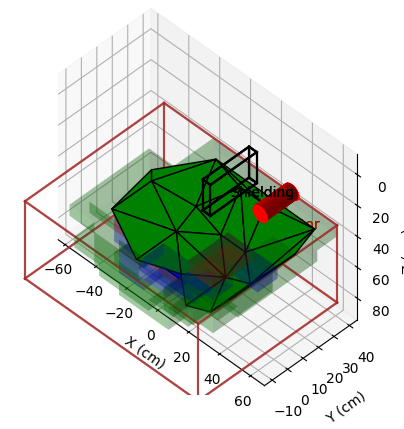

In [280]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(5, 5))
# fig.suptitle(f'Cell Portion of Total Heating for {filename}', fontsize=40)

ax0 = axs
# ax0.set_clip_on(True)
# ax0.set_ylim3d(-1, 45)
cloud = clouds['99'][0]
cell_mask_vox = vox_maker(cloud, midpoints)
# cell_mask_vox = cell_mask_vox & filter_mask
cloud_mask(ax0, cell_mask_vox, sidess[0], color='green')
cloud = clouds['95'][0]
cell_mask_vox = vox_maker(cloud, midpoints)
# cell_mask_vox = cell_mask_vox & filter_mask
cloud_mask(ax0, cell_mask_vox, sidess[0], color='blue')
cloud = clouds['90'][0]
cell_mask_vox = vox_maker(cloud, midpoints)
filter_mask = (midpoints[:, 1]>-1).reshape(cell_mask_vox.shape)
# cell_mask_vox = cell_mask_vox & filter_mask
cloud_mask(ax0, cell_mask_vox, sidess[0], color='red')
# ax0.invert_zaxis()
# ax0.set_clip_on(True)
extra(ax0)
ax0.view_init(elev=0+45, azim=-90+45)